# Imports and setup

In [7]:
# Imports
import requests
import os
import json
from dotenv import load_dotenv
from urllib.parse import urlencode
import webbrowser
import pandas as pd
import numpy as np
import re 

In [2]:
load_dotenv()
# Use a .env file containing "API_TOKEN={your_token}"
API_TOKEN = os.environ.get("API_TOKEN")

NUMBER_OF_RESULT_PER_PAGE=100
PAGE_NUMBER=10

# GitHub action workflow analysis

In [3]:
class Result:
  def __init__(self, full_name, html_url, stargazers_count, watchers_count, language, forks_count, workflow_urls):
    self.full_name = full_name
    self.html_url = html_url
    self.stargazers_count = stargazers_count
    self.watchers_count = watchers_count
    self.language = language
    self.forks_count = forks_count
    self.workflow_urls = workflow_urls


### Retrieve GitHub workflows configuration files

In [4]:
f = open("github-workflows.json", "a")
result = []
for PAGE in range(1, PAGE_NUMBER + 1):
#endpoint = "https://api.github.com/search/repositories?q=workflow+sort%3Astars&s=stars&page=" + str(PAGE) + "&per_page=" + str(NUMBER_OF_RESULT_PER_PAGE)
    
    # Request to retreive X most stargazers repositories on GitHub
    endpoint = "https://api.github.com/search/repositories?q=stars%3A\">+1000\"&path%3A%2F.github%2Fworkflows%2F+&page=" + str(PAGE) + "&per_page=" + str(NUMBER_OF_RESULT_PER_PAGE)
    print("Endpoint: " + endpoint)
    response = requests.get(endpoint, headers = {"Accept": "application/json", "Authorization": f"token {API_TOKEN}"}).json()

    for index in range(len(response.get('items'))):

        # Request to retreive the Workflow list for each repository
        workflowEndpoint = "https://api.github.com/repos/" + response.get('items')[index].get('full_name') + "/actions/workflows?page=" + str(1) + "&per_page=" + str(100)
        print("Workflow Endpoint: " + workflowEndpoint)
        workflowResponse = requests.get(workflowEndpoint, headers = {"Accept": "application/json", "Authorization": f"token {API_TOKEN}"}).json()
        
        workflows = []
        for index_wf in range(len(workflowResponse.get('workflows'))):
            
            # Only contabilize the files with an .yaml or .yml extension
            wf_url_lower = workflowResponse.get('workflows')[index_wf].get('html_url').lower()
            if wf_url_lower != None and (".yaml" in wf_url_lower or ".yml" in wf_url_lower):
                workflows.append((workflowResponse.get('workflows')[index_wf].get('html_url')).replace("github.com", "raw.githubusercontent.com").replace("/blob/", "/"))
        
        # Create a result object for each repository
        result.append(Result(response.get('items')[index].get('full_name'),
                            response.get('items')[index].get('html_url'),
                            response.get('items')[index].get('stargazers_count'),
                            response.get('items')[index].get('watchers_count'),
                            response.get('items')[index].get('language'),
                            response.get('items')[index].get('forks_count'),
                            workflows))
    print("### Step " + str(PAGE) + "/" + str(PAGE_NUMBER) + " ###")
    
f.write(json.dumps([ob.__dict__ for ob in result]))
f.close()

print("Complet!")

Endpoint: https://api.github.com/search/repositories?q=stars%3A">+1000"&path%3A%2F.github%2Fworkflows%2F+&page=1&per_page=100
Workflow Endpoint: https://api.github.com/repos/freeCodeCamp/freeCodeCamp/actions/workflows?page=1&per_page=100
Workflow Endpoint: https://api.github.com/repos/996icu/996.ICU/actions/workflows?page=1&per_page=100
Workflow Endpoint: https://api.github.com/repos/EbookFoundation/free-programming-books/actions/workflows?page=1&per_page=100
Workflow Endpoint: https://api.github.com/repos/jwasham/coding-interview-university/actions/workflows?page=1&per_page=100
Workflow Endpoint: https://api.github.com/repos/vuejs/vue/actions/workflows?page=1&per_page=100
Workflow Endpoint: https://api.github.com/repos/sindresorhus/awesome/actions/workflows?page=1&per_page=100
Workflow Endpoint: https://api.github.com/repos/kamranahmedse/developer-roadmap/actions/workflows?page=1&per_page=100
Workflow Endpoint: https://api.github.com/repos/facebook/react/actions/workflows?page=1&per_p

KeyboardInterrupt: 

### Analyse GitHub workflows configuration files

In [21]:
# Initializing distribution dictionary
distribution = {"windows":0,
                "mac":0,
                "osx":0,
                "ubuntu":0,
                "debian":0,
                "linux":0,
                "alpine":0,
                "centos":0,
                "fedora":0
               }

# Initializing opSys dictionary
opSys = {"windows":0,
         "mac":0,
         "linux":0
        }

# Initializing labels arrays and counters
distributions = ["windows","mac","osx","ubuntu","debian","linux","alpine","centos","fedora"]
OSs = ["windows","mac","linux"]
distCounter = [0] * len(distributions)
opSysCounter = [0] * len(opSys)

# ----------------------------------------------------------------------------------------------

with open('github-workflows.json', "r") as f:
    repositories = json.loads(f.read())
    
    viableRepository = 0 # Keep track of the number of repositories with at least one workflow analyzed
    
    for repoIndex in range(len(repositories)):
        print("### Analyzing: " + str(repositories[repoIndex].get('full_name')) + " ### (" + str(repoIndex) + "/" + str(len(repositories)) +")")
        distCounter = [0] * len(distributions)
        opSysCounter = [0] * len(opSys)
        
        for wfIndex in range(len(repositories[repoIndex].get('workflow_urls'))):
            response = requests.get(repositories[repoIndex].get('workflow_urls')[wfIndex])
            
            if response.status_code is 200: #Only look at the 200 response code
                
                for distNameIndex in range(len(distributions)):
                    distribution_name = distributions[distNameIndex]

                    # Check if the workflow file contain "runs-on: XXX" or "runs-on:XXX"
                    if (("runs-on: " + str(distribution_name)) in str(response.content)) or (("runs-on:" + str(distribution_name)) in str(response.content)):
                        distCounter[distNameIndex] = distCounter[distNameIndex]+1
                        
                        if distribution_name in ["windows"]:
                            opSysCounter[0] = opSysCounter[0]+1
                        elif distribution_name in ["mac","osx"]:
                            opSysCounter[1] = opSysCounter[1]+1
                        elif distribution_name in ["ubuntu","debian","linux","alpine","centos","fedora"]:
                            opSysCounter[2] = opSysCounter[2]+1
        
        print("--- - ---")
        print(distCounter)
        print(opSysCounter)
        
        # The results are normalized between 0 and 1 per distribution
        if sum(distCounter) > 0:
            viableRepository = viableRepository+1
            for distCinxex in range(len(distCounter)):
                distribution[distributions[distCinxex]] = distribution[distributions[distCinxex]] + (distCounter[distCinxex] / sum(distCounter))
        
        # The results are normalized between 0 and 1 per OSes    
        if sum(opSysCounter) > 0:
            for opSysCinxex in range(len(opSysCounter)):
                opSys[OSs[opSysCinxex]] = opSys[OSs[opSysCinxex]] + (opSysCounter[opSysCinxex] / sum(opSysCounter))
            
    
print("Complet!")

print(distribution)
print(opSys)
print(viableRepository)

### Analyzing: freeCodeCamp/freeCodeCamp ### (0/1000)
--- - ---
[0, 0, 0, 14, 0, 0, 0, 0, 0]
[0, 0, 14]
### Analyzing: 996icu/996.ICU ### (1/1000)
--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
### Analyzing: EbookFoundation/free-programming-books ### (2/1000)
--- - ---
[0, 0, 0, 2, 0, 0, 0, 0, 0]
[0, 0, 2]
### Analyzing: jwasham/coding-interview-university ### (3/1000)
--- - ---
[0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 1]
### Analyzing: vuejs/vue ### (4/1000)
--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
### Analyzing: sindresorhus/awesome ### (5/1000)
--- - ---
[0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 1]
### Analyzing: kamranahmedse/developer-roadmap ### (6/1000)
--- - ---
[0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 1]
### Analyzing: facebook/react ### (7/1000)
--- - ---
[0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 1]
### Analyzing: public-apis/public-apis ### (8/1000)
--- - ---
[0, 0, 0, 2, 0, 0, 0, 0, 0]
[0, 0, 2]
### Analyzing: tensorflow/tensorflow ### (9/1000)
--- - ---
[0, 0, 0, 4, 0, 0, 0, 0, 0]
[0, 0, 4

--- - ---
[0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 1]
### Analyzing: huggingface/transformers ### (85/1000)
--- - ---
[0, 0, 0, 11, 0, 0, 0, 0, 0]
[0, 0, 11]
### Analyzing: netdata/netdata ### (86/1000)
--- - ---
[0, 0, 0, 11, 0, 0, 0, 0, 0]
[0, 0, 11]
### Analyzing: reduxjs/redux ### (87/1000)
--- - ---
[0, 0, 0, 2, 0, 0, 0, 0, 0]
[0, 0, 2]
### Analyzing: gohugoio/hugo ### (88/1000)
--- - ---
[0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 1]
### Analyzing: atom/atom ### (89/1000)
--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
### Analyzing: chartjs/Chart.js ### (90/1000)
--- - ---
[0, 0, 0, 5, 0, 0, 0, 0, 0]
[0, 0, 5]
### Analyzing: kdn251/interviews ### (91/1000)
--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
### Analyzing: expressjs/express ### (92/1000)
--- - ---
[0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 1]
### Analyzing: jquery/jquery ### (93/1000)
--- - ---
[0, 0, 0, 2, 0, 0, 0, 0, 0]
[0, 0, 2]
### Analyzing: macrozheng/mall ### (94/1000)
--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
### Analyzing: s

--- - ---
[2, 1, 0, 3, 0, 0, 0, 0, 0]
[2, 1, 3]
### Analyzing: wasabeef/awesome-android-ui ### (168/1000)
--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
### Analyzing: serverless/serverless ### (169/1000)
--- - ---
[3, 0, 0, 3, 0, 0, 0, 0, 0]
[3, 0, 3]
### Analyzing: minimaxir/big-list-of-naughty-strings ### (170/1000)
--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
### Analyzing: junegunn/fzf ### (171/1000)
--- - ---
[0, 1, 0, 2, 0, 0, 0, 0, 0]
[0, 1, 2]
### Analyzing: prettier/prettier ### (172/1000)
--- - ---
[0, 0, 0, 7, 0, 0, 0, 0, 0]
[0, 0, 7]
### Analyzing: aymericdamien/TensorFlow-Examples ### (173/1000)
--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
### Analyzing: square/okhttp ### (174/1000)
--- - ---
[1, 1, 0, 2, 0, 0, 0, 0, 0]
[1, 1, 2]
### Analyzing: juliangarnier/anime ### (175/1000)
--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
### Analyzing: tiangolo/fastapi ### (176/1000)
--- - ---
[0, 0, 0, 9, 0, 0, 0, 0, 0]
[0, 0, 9]
### Analyzing: lydiahallie/javascript-question

--- - ---
[0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 1]
### Analyzing: fastlane/fastlane ### (251/1000)
--- - ---
[0, 0, 0, 4, 0, 0, 0, 0, 0]
[0, 0, 4]
### Analyzing: swisskyrepo/PayloadsAllTheThings ### (252/1000)
--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
### Analyzing: tiimgreen/github-cheat-sheet ### (253/1000)
--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
### Analyzing: microsoft/playwright ### (254/1000)
--- - ---
[1, 2, 0, 21, 0, 0, 0, 0, 0]
[1, 2, 21]
### Analyzing: adobe/brackets ### (255/1000)
--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
### Analyzing: slatedocs/slate ### (256/1000)
--- - ---
[0, 0, 0, 4, 0, 0, 0, 0, 0]
[0, 0, 4]
### Analyzing: FiloSottile/mkcert ### (257/1000)
--- - ---
[0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 1]
### Analyzing: vuetifyjs/vuetify ### (258/1000)
--- - ---
[0, 0, 0, 4, 0, 0, 0, 0, 0]
[0, 0, 4]
### Analyzing: AFNetworking/AFNetworking ### (259/1000)
--- - ---
[0, 1, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0]
### Analyzing: 0voice/interview_internal_reference ##

--- - ---
[1, 1, 0, 1, 0, 0, 0, 0, 0]
[1, 1, 1]
### Analyzing: google/styleguide ### (335/1000)
--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
### Analyzing: kelseyhightower/kubernetes-the-hard-way ### (336/1000)
--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
### Analyzing: geekxh/hello-algorithm ### (337/1000)
--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
### Analyzing: nativefier/nativefier ### (338/1000)
--- - ---
[0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 1]
### Analyzing: carbon-app/carbon ### (339/1000)
--- - ---
[0, 0, 0, 2, 0, 0, 0, 0, 0]
[0, 0, 2]
### Analyzing: jaredpalmer/formik ### (340/1000)
--- - ---
[0, 0, 0, 6, 0, 0, 0, 0, 0]
[0, 0, 6]
### Analyzing: GokuMohandas/MadeWithML ### (341/1000)
--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
### Analyzing: istio/istio ### (342/1000)
--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
### Analyzing: serhii-londar/open-source-mac-os-apps ### (343/1000)
--- - ---
[0, 2, 0, 0, 0, 0, 0, 0, 0]
[0, 2, 0]
### Analyzing: golang-standards/proj

--- - ---
[0, 0, 0, 10, 0, 0, 0, 0, 0]
[0, 0, 10]
### Analyzing: symfony/symfony ### (419/1000)
--- - ---
[0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 1]
### Analyzing: mastodon/mastodon ### (420/1000)
--- - ---
[0, 0, 0, 2, 0, 0, 0, 0, 0]
[0, 0, 2]
### Analyzing: ReactiveX/rxjs ### (421/1000)
--- - ---
[0, 0, 0, 3, 0, 0, 0, 0, 0]
[0, 0, 3]
### Analyzing: fzaninotto/Faker ### (422/1000)
--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
### Analyzing: openai/gym ### (423/1000)
--- - ---
[0, 0, 0, 3, 0, 0, 0, 0, 0]
[0, 0, 3]
### Analyzing: jashkenas/underscore ### (424/1000)
--- - ---
[0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 1]
### Analyzing: amix/vimrc ### (425/1000)
--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
### Analyzing: junegunn/vim-plug ### (426/1000)
--- - ---
[0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 1]
### Analyzing: rapid7/metasploit-framework ### (427/1000)
--- - ---
[0, 0, 0, 4, 0, 0, 0, 0, 0]
[0, 0, 4]
### Analyzing: apolloconfig/apollo ### (428/1000)
--- - ---
[0, 0, 0, 4, 0, 0, 0, 0, 0]
[0, 0

--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
### Analyzing: JedWatson/react-select ### (505/1000)
--- - ---
[0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 1]
### Analyzing: CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers ### (506/1000)
--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
### Analyzing: GoogleChrome/lighthouse ### (507/1000)
--- - ---
[2, 1, 0, 7, 0, 0, 0, 0, 0]
[2, 1, 7]
### Analyzing: ajaxorg/ace ### (508/1000)
--- - ---
[0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 1]
### Analyzing: rust-unofficial/awesome-rust ### (509/1000)
--- - ---
[0, 0, 0, 3, 0, 0, 0, 0, 0]
[0, 0, 3]
### Analyzing: odoo/odoo ### (510/1000)
--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
### Analyzing: fengdu78/Coursera-ML-AndrewNg-Notes ### (511/1000)
--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
### Analyzing: SDWebImage/SDWebImage ### (512/1000)
--- - ---
[0, 1, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0]
### Analyzing: ageron/handson-ml ### (513/1000)
--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]


--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
### Analyzing: pure-css/pure ### (588/1000)
--- - ---
[0, 0, 0, 2, 0, 0, 0, 0, 0]
[0, 0, 2]
### Analyzing: heartcombo/devise ### (589/1000)
--- - ---
[0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 1]
### Analyzing: dmlc/xgboost ### (590/1000)
--- - ---
[0, 0, 0, 3, 0, 0, 0, 0, 0]
[0, 0, 3]
### Analyzing: balderdashy/sails ### (591/1000)
--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
### Analyzing: emberjs/ember.js ### (592/1000)
--- - ---
[0, 0, 0, 3, 0, 0, 0, 0, 0]
[0, 0, 3]
### Analyzing: harvesthq/chosen ### (593/1000)
--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
### Analyzing: pjreddie/darknet ### (594/1000)
--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
### Analyzing: huihut/interview ### (595/1000)
--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
### Analyzing: starship/starship ### (596/1000)
--- - ---
[0, 0, 0, 5, 0, 0, 0, 0, 0]
[0, 0, 5]
### Analyzing: immerjs/immer ### (597/1000)
--- - ---
[0, 0, 0, 3, 0, 0, 0, 0, 0]
[0, 0, 3]
### Analy

--- - ---
[0, 0, 0, 4, 0, 0, 0, 0, 0]
[0, 0, 4]
### Analyzing: apache/kafka ### (673/1000)
--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
### Analyzing: openfaas/faas ### (674/1000)
--- - ---
[0, 0, 0, 2, 0, 0, 0, 0, 0]
[0, 0, 2]
### Analyzing: fabricjs/fabric.js ### (675/1000)
--- - ---
[0, 0, 0, 10, 0, 0, 0, 0, 0]
[0, 0, 10]
### Analyzing: usablica/intro.js ### (676/1000)
--- - ---
[0, 0, 0, 2, 0, 0, 0, 0, 0]
[0, 0, 2]
### Analyzing: vercel/swr ### (677/1000)
--- - ---
[0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 1]
### Analyzing: nsqio/nsq ### (678/1000)
--- - ---
[0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 1]
### Analyzing: NativeScript/NativeScript ### (679/1000)
--- - ---
[0, 1, 0, 4, 0, 0, 0, 0, 0]
[0, 1, 4]
### Analyzing: komeiji-satori/Dress ### (680/1000)
--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
### Analyzing: halo-dev/halo ### (681/1000)
--- - ---
[0, 0, 0, 4, 0, 0, 0, 0, 0]
[0, 0, 4]
### Analyzing: kilimchoi/engineering-blogs ### (682/1000)
--- - ---
[0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0,

--- - ---
[0, 0, 0, 3, 0, 0, 0, 0, 0]
[0, 0, 3]
### Analyzing: necolas/react-native-web ### (756/1000)
--- - ---
[0, 0, 0, 3, 0, 0, 0, 0, 0]
[0, 0, 3]
### Analyzing: floating-ui/floating-ui ### (757/1000)
--- - ---
[0, 0, 0, 4, 0, 0, 0, 0, 0]
[0, 0, 4]
### Analyzing: dotnet-architecture/eShopOnContainers ### (758/1000)
--- - ---
[0, 0, 0, 27, 0, 0, 0, 0, 0]
[0, 0, 27]
### Analyzing: sebastianruder/NLP-progress ### (759/1000)
--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
### Analyzing: onevcat/Kingfisher ### (760/1000)
--- - ---
[0, 1, 0, 1, 0, 0, 0, 0, 0]
[0, 1, 1]
### Analyzing: Reactive-Extensions/RxJS ### (761/1000)
--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
### Analyzing: goldfire/howler.js ### (762/1000)
--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
### Analyzing: vercel/pkg ### (763/1000)
--- - ---
[0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 1]
### Analyzing: uglide/RedisDesktopManager ### (764/1000)
--- - ---
[0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 1]
### Analyzing: libgdx/libgdx ###

--- - ---
[0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 1]
### Analyzing: yt-dlp/yt-dlp ### (838/1000)
--- - ---
[1, 1, 0, 2, 0, 0, 0, 0, 0]
[1, 1, 2]
### Analyzing: Prinzhorn/skrollr ### (839/1000)
--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
### Analyzing: qishibo/AnotherRedisDesktopManager ### (840/1000)
--- - ---
[1, 1, 0, 1, 0, 0, 0, 0, 0]
[1, 1, 1]
### Analyzing: qianguyihao/Web ### (841/1000)
--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
### Analyzing: forem/forem ### (842/1000)
--- - ---
[0, 0, 0, 5, 0, 0, 0, 0, 0]
[0, 0, 5]
### Analyzing: yuzu-emu/yuzu ### (843/1000)
--- - ---
[0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 1]
### Analyzing: DIYgod/RSSHub ### (844/1000)
--- - ---
[0, 0, 0, 11, 0, 0, 0, 0, 0]
[0, 0, 11]
### Analyzing: palantir/blueprint ### (845/1000)
--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
### Analyzing: dhg/Skeleton ### (846/1000)
--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
### Analyzing: google/web-starter-kit ### (847/1000)
--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0

### Analyzing: python-telegram-bot/python-telegram-bot ### (925/1000)
--- - ---
[0, 0, 0, 4, 0, 0, 0, 0, 0]
[0, 0, 4]
### Analyzing: dgraph-io/dgraph ### (926/1000)
--- - ---
[0, 0, 0, 2, 0, 0, 0, 0, 0]
[0, 0, 2]
### Analyzing: streamlit/streamlit ### (927/1000)
--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
### Analyzing: lutzroeder/netron ### (928/1000)
--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
### Analyzing: PaddlePaddle/Paddle ### (929/1000)
--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
### Analyzing: freefq/free ### (930/1000)
--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
### Analyzing: openssl/openssl ### (931/1000)
--- - ---
[0, 0, 0, 12, 0, 0, 0, 0, 0]
[0, 0, 12]
### Analyzing: jitsi/jitsi-meet ### (932/1000)
--- - ---
[0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 1]
### Analyzing: vnpy/vnpy ### (933/1000)
--- - ---
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0]
### Analyzing: InterviewMap/CS-Interview-Knowledge-Map ### (934/1000)
--- - ---
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
### Anal

### Display GitHub workflow analysis results

In [22]:
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [23]:
df1 = pd.DataFrame(list(distribution.values()), index=distributions, columns=['quantity'])

df2 = pd.DataFrame(list(opSys.values()), index=OSs, columns=['quantity'])

display_side_by_side(df1, df2, titles=['Distributions','OSes'])

,quantity
windows,21.010763
mac,27.341320
osx,0.000000
ubuntu,500.335417
debian,0.000000
linux,0.312500
alpine,0.000000
centos,0.000000
fedora,0.000000
,quantity


In [24]:
import matplotlib.pyplot as plt

# Normalize array value between 0 and 100
def normalizePie(array):
    result = [0] * len(array)
    total = sum(array)
    for index in range(len(array)):
        result[index] = array[index] * 100 / total
    return result

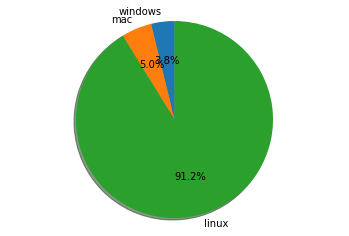

In [25]:
# Display Pie chart of OSes proportion
sizes = normalizePie(list(opSys.values()))

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=OSs, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')

plt.show()